# Adding Weighting To all Calculations

In [1]:
import math
import xarray as xr
import numpy as np
import calendar
import pandas as pd
import datetime
import os
import cftime
import matplotlib.pyplot as plt
from scipy import stats
import sys
import seaborn as sns
from scipy.stats import linregress, pearsonr
sys.path.append('/home/users/chingosa/Functions/')
import CMIPFuncs as func
from multiprocessing import Pool, cpu_count
allow_rechunk=True

##### First off finding the ps variables

### Calculating temperature percentiles by region

In [ ]:
modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')
periods = ['historical', 'ssp245']
variables = ['tas']
percentiles = [0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99]

for model in modelNames.ModelName:
    print(model)
    ds_hist, ds_ssp245 = func.dsRetrieve(variables, model, periods)
    
    ds_hist['tas_MOP_land'] = func.getMeansOverPercentile(ds_hist.tas.where(ds_hist.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
    ds_hist['tas_MOP_ocean'] = func.getMeansOverPercentile(ds_hist.tas.where(ds_hist.landseamask == 0), percentiles, avgOut = ['time', 'lon'])
    
    ds_ssp245['tas_MOP_land'] = func.getMeansOverPercentile(ds_ssp245.tas.where(ds_ssp245.landseamask == 1), percentiles, avgOut = ['time', 'lon'])
    ds_ssp245['tas_MOP_ocean'] = func.getMeansOverPercentile(ds_ssp245.tas.where(ds_ssp245.landseamask == 0), percentiles, avgOut = ['time', 'lon'])

    ds_hist['meanLandTemp_x'] = ds_hist.tas_MOP_land.weighted(ds_hist.landFracWeight * ds_hist.latWeight).mean('lat')
    ds_hist['meanOceanTemp_x'] = ds_hist.tas_MOP_ocean.weighted(ds_hist.oceanFracWeight * ds_hist.latWeight).mean('lat')
    
    ds_ssp245['meanLandTemp_x'] = ds_ssp245.tas_MOP_land.weighted(ds_ssp245.landFracWeight * ds_ssp245.latWeight).mean('lat')
    ds_ssp245['meanOceanTemp_x'] = ds_ssp245.tas_MOP_ocean.weighted(ds_ssp245.oceanFracWeight * ds_ssp245.latWeight).mean('lat')

    ds_hist = ds_hist.drop_vars(['tas'])
    ds_ssp245 = ds_ssp245.drop_vars(['tas'])
    
    ds_dTland = ds_ssp245.meanLandTemp_x - ds_hist.meanLandTemp_x
    ds_dTland = ds_dTland.rename('ds_dTland')
    ds_dTocean = ds_ssp245.meanOceanTemp_x - ds_hist.meanOceanTemp_x
    ds_dTocean = ds_dTocean.rename('ds_dTocean')


    ds = xr.merge([ds_dTland,ds_dTocean])
    
    ds_ssp245.to_netcdf(f'tas_ssp245_{model}.nc')
    ds_hist.to_netcdf(f'tas_hist_{model}.nc')
    ds.to_netcdf(f'tas_changein_{model}.nc')


### Calculating mean regional temperature changes 

In [6]:
#### Just getting the mean values

modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')
periods = ['historical', 'ssp245']
variables = ['tas']

for model in ['HadGEM3-GC31-LL']:
    print(model)
    ds_hist, ds_ssp245 = func.dsRetrieve(variables, model, periods)
    
    ds_hist['tas_mean_land'] = ds_hist.tas.where(ds_hist.landseamask == 1).mean(['time', 'lon'])
    ds_hist['tas_mean_ocean'] = ds_hist.tas.where(ds_hist.landseamask == 0).mean(['time', 'lon'])
    
    ds_ssp245['tas_mean_land'] = ds_ssp245.tas.where(ds_ssp245.landseamask == 1).mean(['time', 'lon'])
    ds_ssp245['tas_mean_ocean'] = ds_ssp245.tas.where(ds_ssp245.landseamask == 0).mean(['time', 'lon'])

    ds_hist['meanLandTemp_x'] = ds_hist.tas_mean_land.weighted(ds_hist.landFracWeight * ds_hist.latWeight).mean('lat')
    ds_hist['meanOceanTemp_x'] = ds_hist.tas_mean_ocean.weighted(ds_hist.oceanFracWeight * ds_hist.latWeight).mean('lat')
    
    ds_ssp245['meanLandTemp_x'] = ds_ssp245.tas_mean_land.weighted(ds_ssp245.landFracWeight * ds_ssp245.latWeight).mean('lat')
    ds_ssp245['meanOceanTemp_x'] = ds_ssp245.tas_mean_ocean.weighted(ds_ssp245.oceanFracWeight * ds_ssp245.latWeight).mean('lat')

    ds_hist = ds_hist.drop_vars(['tas'])
    ds_ssp245 = ds_ssp245.drop_vars(['tas'])
    
    ds_dTland = ds_ssp245.meanLandTemp_x - ds_hist.meanLandTemp_x
    ds_dTland = ds_dTland.rename('ds_dTland_mean')
    ds_dTocean = ds_ssp245.meanOceanTemp_x - ds_hist.meanOceanTemp_x
    ds_dTocean = ds_dTocean.rename('ds_dTocean_mean')


    ds = xr.merge([ds_dTland,ds_dTocean])
    

    ds.to_netcdf(f'tas_changein_{model}_mean.nc')


HadGEM3-GC31-LL


### Recreating figure 2, better matching

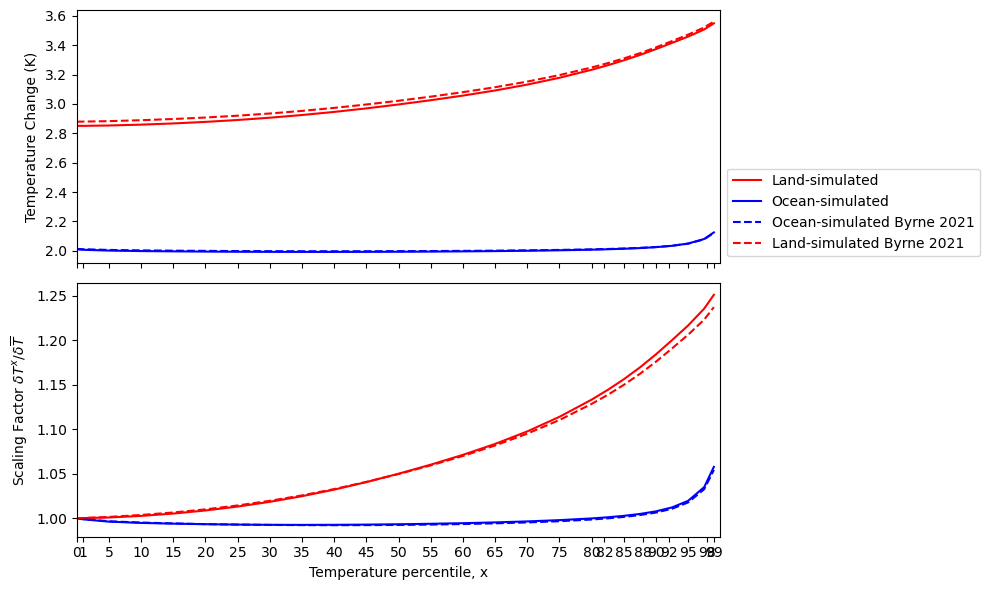

In [7]:
Show_Byrne = True
doFixRH = False
## Reloading Data and Calculating Scaling factors and quantiles

###----------------------------------------------------------------------------------------------------------------------------------###
#        Processing percentileDifferences_all_flt.csv
###----------------------------------------------------------------------------------------------------------------------------------### 


modelNames = pd.read_excel('/home/users/chingosa/CMIP6/CMIP6Models.xlsx')
model = 'ACCESS-CM2'
ds = xr.Dataset({})
for model in modelNames.ModelName:
    new = xr.open_dataset(f'tas_changein_{model}.nc')
    
    new_mean = xr.open_dataset(f'tas_changein_{model}_mean.nc')
    new['ds_dTland_sf'] = new.ds_dTland / new_mean.ds_dTland_mean
    new['ds_dTocean_sf'] = new.ds_dTocean / new_mean.ds_dTocean_mean
    
    new = new.expand_dims(model = [model])
    new = new.drop_vars('height', errors = 'ignore')
    ds = xr.merge([ds, new])



###----------------------------------------------------------------------------------------------------------------------------------###
#       Plotting your own data to recreate Figure 2 from Byrne 2021
###----------------------------------------------------------------------------------------------------------------------------------### 
# Initalize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex = True)

#ax1
# ax1.fill_between(df_mean.percentile[df_mean['landOcean'] == 1], df_mean.q1[df_mean['landOcean'] == 1], df_mean.q3[df_mean['landOcean'] == 1], color='r', alpha = 0.1)
ax1.plot(ds.MOP, ds.ds_dTland.mean('model').values, color = 'r', label = 'Land-simulated')
ax1.plot(ds.MOP, ds.ds_dTocean.mean('model').values, color = 'b', label = 'Ocean-simulated')

ax2.plot(ds.MOP, ds.ds_dTland_sf.mean('model').values, color = 'r')
ax2.plot(ds.MOP, ds.ds_dTocean_sf.mean('model').values, color = 'b')

#ax2
# ax2.fill_between(df_mean.percentile[df_mean['landOcean'] == 1], df_mean.sf_q1[df_mean['landOcean'] == 1], df_mean.sf_q3[df_mean['landOcean'] == 1], color='r', alpha = 0.1)
# for i in [0,1]:
#     ax2.plot(df_mean.percentile[df_mean['landOcean'] == i], df_mean.sf_mean[df_mean['landOcean'] == i], color = ['b', 'r'][i])
###----------------------------------------------------------------------------------------------------------------------------------###
#     Processing Byrne 2021 Data
###----------------------------------------------------------------------------------------------------------------------------------### 
if Show_Byrne:
    df_Byrne = pd.read_csv('41561_2021_828_MOESM4_ESM.csv')
    
    for i in [0,1]:
        ax1.plot(df_Byrne['# Panel (a): X data'], df_Byrne[['Panel (a): Y data (solid blue line)', 'Panel (a): Y data (solid red line)'][i]], color = ['b', 'r'][i], label = ['Ocean-simulated Byrne 2021', 'Land-simulated Byrne 2021'][i], linestyle = '--')
        ax2.plot(df_Byrne['Panel (b): X data'], df_Byrne[['Panel (b): Y data (solid blue line)', 'Panel (b): Y data (solid red line)'][i]], color = ['b', 'r'][i], linestyle = '--')
    
    if doFixRH: ax1.plot(df_Byrne['# Panel (a): X data'], df_Byrne['Panel (a): Y data (dotted black line)'], c = 'k', linestyle = '--', label = 'Byrne 2021, fixed RH')

###----------------------------------------------------------------------------------------------------------------------------------###
#    Processing our fixRH calculations of dT_L^x
###----------------------------------------------------------------------------------------------------------------------------------### 
if doFixRH:
    Fix_RH = pd.read_csv(f'Fixed_RH_Theory_All.csv')
    Fix_RH_means = Fix_RH.groupby(['percentile'], as_index=False).dT_L_x.mean()
    ax1.plot(Fix_RH_means.percentile, Fix_RH_means.dT_L_x, c = 'k', label = 'fixed RH')

    df = pd.read_csv(f'percentileDifferences_all_flt.csv')
    df = df.query('landOcean == 1').reset_index(drop=True)
    
    Fix_RH['tChange_sf'] = Fix_RH.dT_L_x/df.meanChangeRg
    Fix_RH_means = Fix_RH.groupby(['percentile'], as_index=False).tChange_sf.mean()
    ax2.plot(Fix_RH_means.percentile, Fix_RH_means.tChange_sf, c = 'k')

#Labels, Axis, legend
ax1.legend(loc = 3, bbox_to_anchor = (1, 0))

ax1.set_xlim(0,100)
ax1.set_ylabel('Temperature Change (K)')
ax2.set_ylabel('Scaling Factor $\delta T^x / \delta \overline{T}$')
ax2.set_xlabel('Temperature percentile, x')
xticks = ds.MOP[~ds.MOP.isin([2, 98])]
ax2.set_xticks(np.round(xticks).astype(int))
fig.tight_layout()
fig.show()
